In [1]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from torchvision.models import resnet18
from glob import glob
import io
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn

In [23]:
impact = "erase_for_security"
not_impact = "erase_for_security"

In [24]:
df_impact = pd.read_csv(impact)
df_not_impact = pd.read_csv(not_impact)

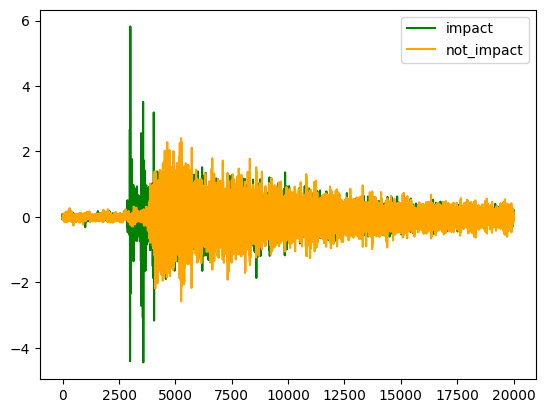

In [50]:
# 0.1sec 동안 20000개
N = 20000
dt = 0.000005
fs = N*10
FrameSize = 2000
nFFT = 128

# 데이터 보정 10을 곱해야 됨. (나중에 왜 이런식으로 데이터를 저장해놓았는지 여쭤보기)
impact = df_impact['V-111'][:N]
not_impact = df_not_impact['V-110'][:N]
impact = np.array(impact)
not_impact = np.array(not_impact)

t = np.arange(N)
plt.plot(t, impact, color='green', label="impact")
plt.plot(t, not_impact, color='orange', label='not_impact')

plt.legend()
plt.show()

In [51]:
max_abs_idx = np.argmax(np.abs(impact))
start_idx = max_abs_idx - FrameSize//2
end_idx = max_abs_idx + FrameSize//2
if start_idx < 0:
    end_idx -= start_idx
    start_idx = 0
elif end_idx >= N:
    start_idx -= end_idx-(N-1)
    end_idx = N-1
if start_idx < 0: raise Exception("input data indexing error")
impact = impact[start_idx: end_idx]

In [52]:
max_abs_idx = np.argmax(np.abs(not_impact))
start_idx = max_abs_idx - FrameSize//2
end_idx = max_abs_idx + FrameSize//2
if start_idx < 0:
    end_idx -= start_idx
    start_idx = 0
elif end_idx >= N:
    start_idx -= end_idx-(N-1)
    end_idx = N-1
if start_idx < 0: raise Exception("input data indexing error")
not_impact = not_impact[start_idx: end_idx]

In [53]:
win = signal.windows.hann(nFFT)
# SFT = signal.ShortTimeFFT(win=win, hop=1, fs=fs, scale_to='psd', phase_shift=0)
SFT = signal.ShortTimeFFT(win=win, hop=1, fs=fs, scale_to='magnitude', phase_shift=0)
zData_impact = SFT.stft(impact, p0=0, p1=FrameSize)
zData_not_impact = SFT.stft(not_impact, p0=0, p1=FrameSize)
absZ_impact = np.abs(zData_impact)
absZ_not_impact = np.abs(zData_not_impact)
print("zData: ", absZ_impact.shape)

zData:  (65, 2000)


In [54]:
xData = np.arange(1, FrameSize+1)*SFT.delta_t
# yData = np.arange(1, nFFT+1)*SFT.delta_f
yData = SFT.f
y_ub = 25000
yData = yData[np.where(yData <= y_ub)]
absZ_impact = absZ_impact[:yData.shape[0], :]
absZ_not_impact = absZ_not_impact[:yData.shape[0], :]
print("xData : ", xData.shape)
print("yData : ", yData.shape)

xData :  (2000,)
yData :  (17,)


In [74]:
colorMax_impact, colorMin_impact = absZ_impact.max(), absZ_impact.min()
# Black #000000
# magenta #c20078
# Blue #0343df
# Cyan #00ffff
# Green #15b01a
# yellow #ffff14
# OrangeRed #fe420f
# Red #e50000
# White #ffffff
colors = ['#000000', '#c20078', '#0343df', '#00ffff', '#15b01a', '#ffff14', '#fe420f', '#e50000', '#ffffff']

norm_impact = plt.Normalize(colorMax_impact, colorMin_impact)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

levels_impact = [0, colorMin_impact]
for i in range(1, 8): levels_impact.append(colorMin_impact + i * (colorMax_impact - colorMin_impact) / 9)
levels_impact.append(colorMax_impact)

colormapping_impact = cm.ScalarMappable(norm=norm_impact, cmap=cmap)
levels_impact

[0,
 1.613877530584661e-05,
 0.13509086104117154,
 0.27016558330703727,
 0.40524030557290297,
 0.5403150278387686,
 0.6753897501046343,
 0.8104644723705,
 0.9455391946363657,
 1.2156886391680972]

In [75]:
colorMax_not_impact, colorMin_not_impact = absZ_not_impact.max(), absZ_not_impact.min()
# Black #000000
# magenta #c20078
# Blue #0343df
# Cyan #00ffff
# Green #15b01a
# yellow #ffff14
# OrangeRed #fe420f
# Red #e50000
# White #ffffff
colors = ['#000000', '#c20078', '#0343df', '#00ffff', '#15b01a', '#ffff14', '#fe420f', '#e50000', '#ffffff']

norm_not_impact = plt.Normalize(colorMax_not_impact, colorMin_not_impact)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

levels_not_impact = [0, colorMin_not_impact]
for i in range(1, 8): levels_not_impact.append(colorMin_not_impact + i * (colorMax_not_impact - colorMin_not_impact) / 9)
levels_not_impact.append(colorMax_not_impact)

colormapping_not_impact = cm.ScalarMappable(norm=norm_not_impact, cmap=cmap)
levels_not_impact

[0,
 1.7378795849002336e-05,
 0.07537269957707234,
 0.1507280203582957,
 0.22608334113951903,
 0.30143866192074237,
 0.3767939827019657,
 0.45214930348318905,
 0.5275046242644122,
 0.678215265826859]

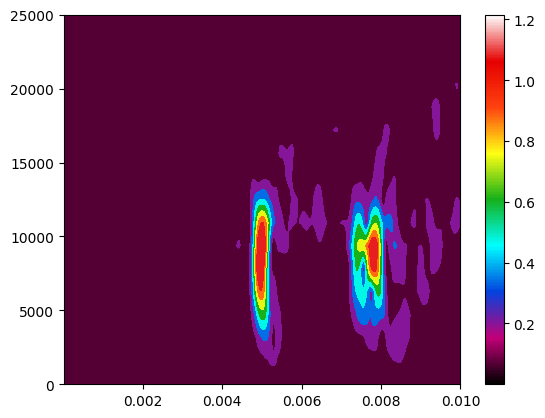

In [78]:
plt.colorbar(colormapping_impact, ax=plt.gca())
plt.contourf(xData, yData, absZ_impact, levels=levels_impact, cmap=cmap, norm=norm_impact)

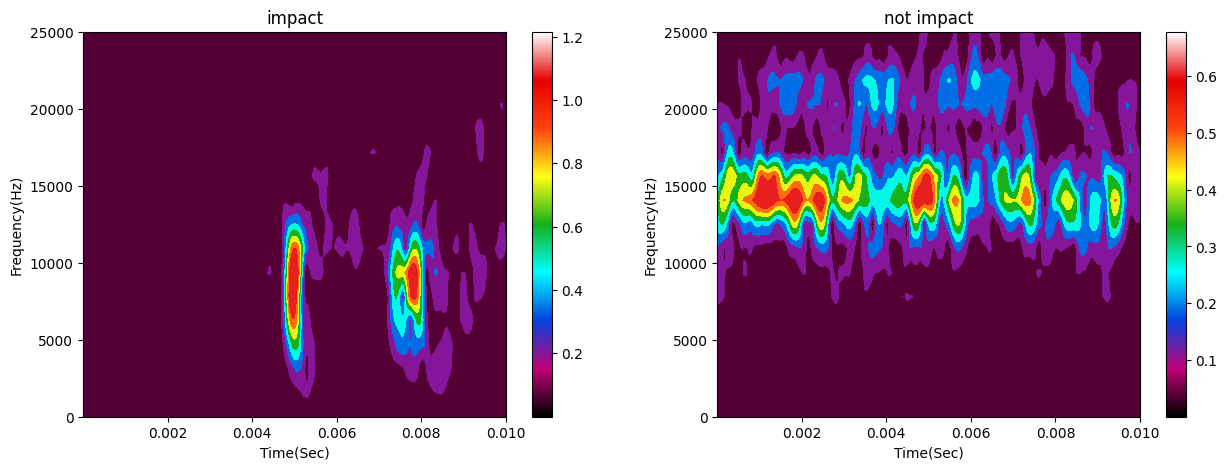

In [87]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)

plt.colorbar(colormapping_impact, ax=ax1)
ax1.contourf(xData, yData, absZ_impact, levels=levels_impact, cmap=cmap, norm=norm_impact)
ax1.set_xlabel('Time(Sec)')
ax1.set_ylabel('Frequency(Hz)')
ax1.set_title('impact')

# ====== accuracy Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
plt.colorbar(colormapping_not_impact, ax=ax2)
ax2.contourf(xData, yData, absZ_not_impact, levels=levels_not_impact, cmap=cmap, norm=norm_not_impact)
ax2.set_xlabel('Time(Sec)')
ax2.set_ylabel('Frequency(Hz)')
ax2.set_title('not impact')

plt.savefig("impact vs not_impact.png", dpi=400)